<a href="https://www.kaggle.com/code/drondasgupta/car-or-truck-cnn-resnet50-model?scriptVersionId=107746813" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

from numpy.random import seed
seed(41)
import tensorflow as tf
tf.random.set_seed(42)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Objective
The objective of this code is to create a Convolutional Neural Net (CNN) that takes a 2D image and classifies it as a 'Car' or a 'Truck', depending on its features.

First, we will import and set up a few important libraries:

In [2]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [3]:
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
# warnings.filterwarnings("ignore") # to clean up output cells

Now, we are going to load our data, which consists of one folder of training images (training set) and one folder of validation images (validation set).

We will also create a pipeline that modifies our image to a float value and autotunes it.

In [4]:
# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    '../input/car-or-truck/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    '../input/car-or-truck/valid',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 5117 files belonging to 2 classes.


2022-10-05 05:51:07.455518: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-05 05:51:07.465539: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-05 05:51:07.466255: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-05 05:51:07.467956: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 5051 files belonging to 2 classes.


## Dropout
Dropout can be added to dense, convolutional and pooling layers by putting the following line of code after the layer (rate is a hyperparameter, selected as 0.3 here):

In [5]:
layers.Dropout(rate = 0.3)

In a CNN, it is usually only used after the pooling layers.

## Early Stopping
Early stopping can be added to prevent overfitting by stopping the learning when validation loss stops increasing. It can be defined as a callbacks.EarlyStopping object and added as an array for the 'callbacks' hyperparameter in model.fit():

In [6]:
from tensorflow.keras import callbacks

early_stopping = callbacks.EarlyStopping(
    min_delta = 0.001,
    patience = 5,
    restore_best_weights = True
)

# history = model.fit(
#     X_train, y_train,
#     validation_data = (X_valid, y_valid),
#     callbacks = [early_stopping]
# )

## Data Augmentation
Data augmentation gives the model a more generalized input by performing linear transformation on the images (for this dataset, rotation, contrast and horizontal flips make the most sense).

In [7]:
from tensorflow.keras.layers.experimental import preprocessing
# augment = keras.Sequential([
#     # preprocessing.RandomContrast(factor=0.5),
#     preprocessing.RandomFlip(mode='horizontal'), # meaning, left-to-right
#     # preprocessing.RandomFlip(mode='vertical'), # meaning, top-to-bottom
#     preprocessing.RandomWidth(factor=0.15), # horizontal stretch
#     preprocessing.RandomRotation(factor=0.03),
#     preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
# ])

## Regularized ResNet50 model

In [8]:
resNet = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=[128, 128, 3]
)

model = keras.Sequential([
    layers.InputLayer(input_shape=[128, 128, 3]),
    
    # Data Augmentation
    preprocessing.RandomContrast(factor=0.10),
    preprocessing.RandomFlip(mode='horizontal'),
    preprocessing.RandomRotation(factor=0.10),
    
    # Pretrained ResNet base
    resNet,
    
    # Custom Head
    layers.BatchNormalization(renorm=True),
    layers.Flatten(),
    layers.Dense(8, activation='relu'),
    layers.Dropout(rate = 0.3),
    layers.Dense(1, activation='sigmoid'),
])

94781440/94765736 [==============================] - 1s 0us/step


2022-10-05 05:51:14.871196: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-10-05 05:51:22.878328: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


80/80 [==============================] - 43s 360ms/step - loss: 0.6639 - binary_accuracy: 0.5773 - val_loss: 1.1489 - val_binary_accuracy: 0.4215
Epoch 2/50
80/80 [==============================] - 14s 171ms/step - loss: 0.5405 - binary_accuracy: 0.6768 - val_loss: 0.6959 - val_binary_accuracy: 0.4213
Epoch 3/50
80/80 [==============================] - 14s 171ms/step - loss: 0.4198 - binary_accuracy: 0.8091 - val_loss: 5.2155 - val_binary_accuracy: 0.4215
Epoch 4/50
80/80 [==============================] - 14s 171ms/step - loss: 0.3926 - binary_accuracy: 0.8329 - val_loss: 6.1919 - val_binary_accuracy: 0.4215
Epoch 5/50
80/80 [==============================] - 14s 171ms/step - loss: 0.3390 - binary_accuracy: 0.8743 - val_loss: 3.7110 - val_binary_accuracy: 0.4215
Epoch 6/50
80/80 [==============================] - 14s 172ms/step - loss: 0.3249 - binary_accuracy: 0.8781 - val_loss: 1.3640 - val_binary_accuracy: 0.4340
Epoch 7/50
80/80 [==============================] - 14s 171ms/step - 

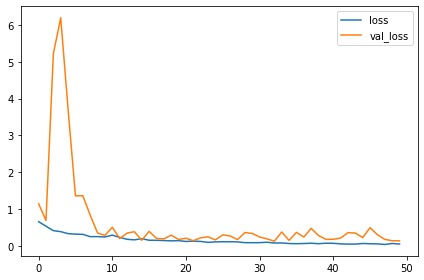

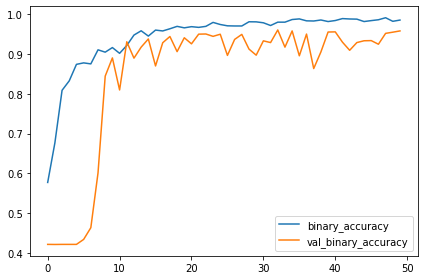

In [9]:
optimizer = tf.keras.optimizers.Adam(epsilon=0.01)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=50,
)

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

The training and validation curves plateau at roughly the same time. Therefore, the model is not overfitting.
It has a better validation accuracy (95%) than the custom convnet designed earlier (90%).

## Result
Thus, we have successfully created a CNN that can classify Cars vs. Trucks given an image, with around 95% accuracy.